ValueError: min() arg is an empty sequence

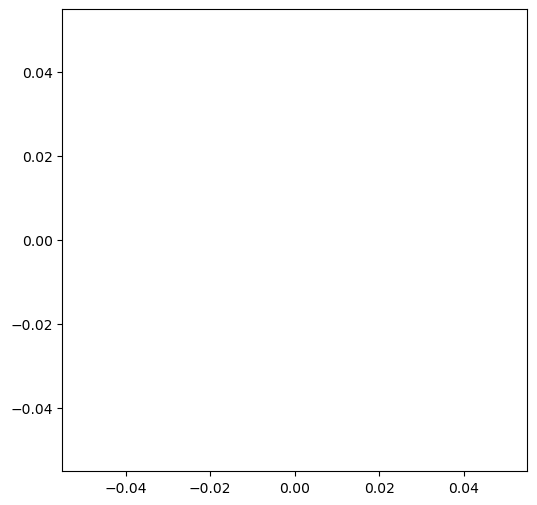

In [53]:
import re
import matplotlib.pyplot as plt

with open("logs/training_log.log", 'r') as f:
    log_text = f.read()

gt_vals = []
pred_vals = []

# Extract GT and Pred
for match in re.finditer(r"GT: ([\d.]+), Pred: ([\d.]+)", log_text):
    gt_vals.append(float(match.group(1)))
    pred_vals.append(float(match.group(2)))

gt_vals = gt_vals[-1000:]
pred_vals = pred_vals[-1000:]

plt.figure(figsize=(6, 6))
plt.scatter(gt_vals, pred_vals, alpha=0.6, edgecolor='k')
plt.plot([min(gt_vals), max(gt_vals)], [min(gt_vals), max(gt_vals)], 'r--', label="Ideal (y=x)")
plt.title("GT vs Pred")
plt.xlabel("GT")
plt.ylabel("Pred")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import re
import matplotlib.pyplot as plt
from pathlib import Path

LOG_PATH = Path("logs/baseline2.log")  # updated to match the new trainer

if not LOG_PATH.exists():
    raise FileNotFoundError(f"Log file not found: {LOG_PATH}")

log_text = LOG_PATH.read_text(encoding="utf-8", errors="ignore")

# ---------------------------------------
# Robust float pattern (handles 1.23, -4., .5, 1e-3, -2.1E+05)
# ---------------------------------------
FLOAT = r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?"

# ---------------------------------------
# Parse Train Eval and Validation Eval
# New log lines look like:
#  "... Epoch {epoch} Step {step} Train Eval: MSE: x, MAE: y, MGEH: z, MAPE: a, R2: b"
#  "... Epoch {epoch} Step {step} Validation Eval: MSE: x, MAE: y, MGEH: z, MAPE: a, R2: b (stage S/T, lr=1e-3)"
# ---------------------------------------
train_steps, train_mae, train_mgeh = [], [], []
val_steps, val_mae, val_mgeh = [], [], []
val_stage_idx, val_lr = [], []

# --- Train Eval lines ---
pattern_train = re.compile(
    rf"Epoch\s+(?P<epoch>\d+)\s+Step\s+(?P<step>\d+)\s+Train\s+Eval:\s*"
    rf"RMSE:\s*(?P<rmse>{FLOAT}),\s*MAE:\s*(?P<mae>{FLOAT}),\s*MGEH:\s*(?P<mgeh>{FLOAT}),\s*R2:\s*(?P<r2>{FLOAT})",
    re.IGNORECASE
)

pattern_val = re.compile(
    rf"Epoch\s+(?P<epoch>\d+)\s+Step\s+(?P<step>\d+)\s+Validation\s+Eval:\s*"
    rf"RMSE:\s*(?P<rmse>{FLOAT}),\s*MAE:\s*(?P<mae>{FLOAT}),\s*MGEH:\s*(?P<mgeh>{FLOAT}),\s*R2:\s*(?P<r2>{FLOAT})"
    rf"(?:\s*\(stage\s+(?P<stage_cur>\d+)\s*/\s*(?P<stage_total>\d+)\s*,\s*lr\s*=\s*(?P<lr>{FLOAT})\s*\))?",
    re.IGNORECASE
)

# You might have timestamps/levels before "Epoch ...", so search with finditer over the whole file.
# We'll index steps sequentially for plotting (like your original code).
t_idx = 0
for m in pattern_train.finditer(log_text):
    t_idx += 1
    train_steps.append(t_idx)
    # groups: 1=epoch, 2=step, 3=mse, 4=mae, 5=mgeh
    train_mae.append(float(m.group(4)))
    train_mgeh.append(float(m.group(5)))

v_idx = 0
for m in pattern_val.finditer(log_text):
    v_idx += 1
    val_steps.append(v_idx)
    # groups: 1=epoch, 2=step, 3=mse, 4=mae, 5=mgeh, 6=stage_idx, 7=stage_total, 8=lr
    val_mae.append(float(m.group(4)))
    val_mgeh.append(float(m.group(5)))
    # Stage / LR may be missing in older lines; store None if not present
    stage_val = int(m.group(6)) if m.group(6) is not None else None
    lr_val = float(m.group(8)) if m.group(8) is not None else None
    val_stage_idx.append(stage_val)
    val_lr.append(lr_val)

# ---------------------------------------
# Helper: find indices where LR stage changes (for vertical lines)
# ---------------------------------------
def stage_change_indices(stages):
    idxs = []
    prev = None
    for i, s in enumerate(stages, start=1):
        if s is None:
            continue
        if prev is None:
            prev = s
            continue
        if s != prev:
            idxs.append(i)
            prev = s
    return idxs

stage_boundaries = stage_change_indices(val_stage_idx)

# ---------------------------------------
# Plot MAE curve
# ---------------------------------------
if train_steps or val_steps:
    plt.figure(figsize=(9, 4))
    if train_steps:
        plt.plot(train_steps, train_mae, label="Train Eval MAE")
    if val_steps:
        plt.plot(val_steps, val_mae, label="Validation Eval MAE")
        # draw stage boundaries if we have them
        for sb in stage_boundaries:
            plt.axvline(sb, linestyle="--", alpha=0.5)
    plt.title("Eval MAE vs Evaluation Step")
    plt.xlabel("Evaluation Step")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---------------------------------------
    # Plot MGEH curve
    # ---------------------------------------
    plt.figure(figsize=(9, 4))
    if train_steps:
        plt.plot(train_steps, train_mgeh, label="Train Eval MGEH")
    if val_steps:
        plt.plot(val_steps, val_mgeh, label="Validation Eval MGEH")
        for sb in stage_boundaries:
            plt.axvline(sb, linestyle="--", alpha=0.5)
    plt.title("Eval MGEH vs Evaluation Step")
    plt.xlabel("Evaluation Step")
    plt.ylabel("MGEH")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No Eval lines found in log.")

ValueError: invalid literal for int() with base 10: '0.195177'

In [46]:
val_mgeh

[]